# Dermatological moles segmentation

### import the libraries

In [ ]:
import os

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

import numpy as np

import random

import matplotlib.pyplot as plt

### download the data

In [3]:
!curl -OL https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
!curl -OL https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  602M  100  602M    0     0  8223k      0  0:01:15  0:01:15 --:--:-- 8945k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5859k  100 5859k    0     0  2029k      0  0:00:02  0:00:02 --:--:-- 2029k


### unzip the data

In [ ]:
!unzip ISBI2016_ISIC_Part1_Training_Data.zip -d images
!unzip ISBI2016_ISIC_Part1_Training_GroundTruth.zip -d annotations

### check if GPU is used

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Core parameters used

In [3]:
# Resizing the images
img_size = (160, 160)

# Number of classes (binary: black or white, thus one class sufficient)
num_classes = 1

# Batch size of 32 
batch_size = 32

## Preprocessing
### sort data: training images and training ground truth  

In [4]:
# path to training data and ground truth
input_dir = "images/ISBI2016_ISIC_Part1_Training_Data/"
target_dir = "annotations/ISBI2016_ISIC_Part1_Training_GroundTruth/"

# sort input images by name
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

# sort segmentation masks by name
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

# print number of total images
print("Number of samples:", len(input_img_paths))

# verify for the first 5 images that they are correctly aligned with their segmentation masks
for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)


Number of samples: 900
C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\images\ISIC_0000000.jpg | C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\annotations\ISIC_0000000_Segmentation.png
C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\images\ISIC_0000001.jpg | C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\annotations\ISIC_0000001_Segmentation.png
C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\images\ISIC_0000002.jpg | C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\annotations\ISIC_0000002_Segmentation.png
C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\images\ISIC_0000004.jpg | C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical 1\Normal_Task\annotations\ISIC_0000004_Segmentation.png
C:\Users\Hasan\Desktop\Barcelona_Data\FIB_Courses\DLMIA\Practical

### Displaying an example image of the dataset and its segmentation

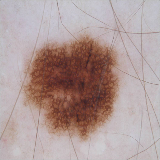

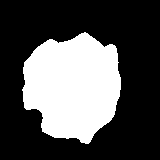

In [5]:
display(load_img(input_img_paths[13], target_size=img_size))

# Display auto-contrast version of corresponding target
display(ImageOps.autocontrast(load_img(target_img_paths[13], target_size=img_size)))



### load all images from file into python datastructure and already resize them

In [6]:
all_images = [load_img(i_path, target_size=img_size) for i_path in input_img_paths]

all_masks = [load_img(t_path, target_size=img_size, color_mode="grayscale") for t_path in target_img_paths]

### convert to numpy array and normalize the data to [0,1]

In [7]:
all_images_normalized = [np.array(image, dtype='float32')/255 for image in all_images]

all_masks_normalized = [np.array(image, dtype='float32')/255 for image in all_masks]

### convert to numpy arrays

In [8]:
all_images_normalized = np.array(all_images_normalized)

all_masks_normalized = np.array(all_masks_normalized)

### add new axis for adding an output channel: black or white (900, 160, 160) -> (900, 160, 160, 1)

In [9]:
all_masks_normalized = all_masks_normalized[..., np.newaxis]

### check shapes

In [10]:
print(all_images_normalized.shape)
print(all_masks_normalized.shape)

(900, 160, 160, 3)
(900, 160, 160, 1)


## Model architecture
### define the U-Net model

In [11]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    skips = []
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(8, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skips.append(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(.2)(x)

    for filters in [16,24,32]:
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        skips.append(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        x = layers.Dropout(.2)(x)


    filters = 32
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(2)(x)

    x = layers.Dropout(.2)(x)

    ### [Second half of the network: upsampling inputs] ###

    for i, filters in enumerate([24,16,8], start=1):
        x = layers.Concatenate()([x, skips[-i]])

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.UpSampling2D(2)(x)

        x = layers.Dropout(.2)(x)

    x = layers.Concatenate()([x, skips[0]])

    # Add a per-pixel classification layer with sigmoid as non linear activation function
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x) 

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

### free up RAM in case the model definition cells were run multiple times and build model

In [12]:
keras.backend.clear_session()

model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 160, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training and validation data
### split our img paths into a training and a validation set:

In [13]:
# take 10% of all available images for the validation set
val_samples = int(len(all_images_normalized) * 0.1)

# shuffle input images and corresponding masks to introduce randomness, but same random seed that shuffle keeps them aligned
random.Random(63).shuffle(all_images_normalized)
random.Random(63).shuffle(all_masks_normalized)

# assign training set
train_imgs = all_images_normalized[:-val_samples]
train_msks = all_masks_normalized[:-val_samples]

# assign validation set
val_imgs = all_images_normalized[-val_samples:]
val_msks = all_masks_normalized[-val_samples:]

train_gen = (train_imgs, train_msks)
val_gen = (val_imgs, val_msks)

### check lengths and shapes

In [14]:
print(len(train_imgs), len(val_imgs))
print(train_imgs.shape)
print(train_msks.shape)
print(val_imgs.shape)
print(val_msks.shape)

810 90
(810, 160, 160, 3)
(810, 160, 160, 1)
(90, 160, 160, 3)
(90, 160, 160, 1)


## Data augmentation: 
### execute the next 4 cells only if data augmentation should be applied

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
test_dataset = tf.data.Dataset.from_tensor_slices((val_imgs, val_msks))

### check if shapes are correct: for input: (160, 160, 3), for mask: (160, 160, 1)

In [16]:
for x,y in train_dataset:
    print(x.shape, y.shape)
    break

(160, 160, 3) (160, 160, 1)


### Augmentations: Flippings and Rotations

In [17]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    # augmentations that dont move the image can be added here
    self.augment_inputs = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical", seed=seed),
      layers.RandomRotation(0.2, seed=seed+1),
    ])
    
    self.augment_labels = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical", seed=seed),
      layers.RandomRotation(0.2, seed=seed+1),
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

### map augmentations to training set

In [18]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(1000)
    .batch(batch_size)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(batch_size)

### only execute if SGD optimizer should be used

In [16]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.01)

### Configure the model for training.
### We use the binary cross entropy as the model segments into 0 (black) or 1 (white)

In [19]:
model.compile(optimizer="adam", loss="binary_crossentropy", # optimizer=opt for SGD optimizer
              metrics=['accuracy',
                       keras.metrics.Recall(), # is sensitivity
                       keras.metrics.FalseNegatives(), 
                       keras.metrics.FalsePositives(), 
                       keras.metrics.TrueNegatives(),
                       keras.metrics.TruePositives(),
                       keras.metrics.AUC()]) # area under roc curve

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoint_best.h5", save_best_only=True)
]


## VERSION 1: without data augmentation
### Train the model, doing validation at the end of each epoch.

In [18]:
epochs = 50
model_history = model.fit(train_imgs, train_msks, epochs=epochs, batch_size=batch_size, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
26/26 [==============================] - 10s 158ms/step - loss: 0.6655 - accuracy: 0.6073 - recall: 0.3707 - false_negatives: 3562982.0000 - false_positives: 4580636.0000 - true_negatives: 10493617.0000 - true_positives: 2098765.0000 - auc: 0.5606 - val_loss: 0.5399 - val_accuracy: 0.7681 - val_recall: 0.0000e+00 - val_false_negatives: 534289.0000 - val_false_positives: 7.0000 - val_true_negatives: 1769704.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.6980
Epoch 2/50
26/26 [==============================] - 2s 79ms/step - loss: 0.4923 - accuracy: 0.7896 - recall: 0.4731 - false_negatives: 2983339.0000 - false_positives: 1379463.0000 - true_negatives: 13694790.0000 - true_positives: 2678408.0000 - auc: 0.7968 - val_loss: 0.5093 - val_accuracy: 0.7681 - val_recall: 0.0000e+00 - val_false_negatives: 534289.0000 - val_false_positives: 1.0000 - val_true_negatives: 1769710.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.7196
Epoch 3/50
26/26 [==============================

26/26 [==============================] - 2s 81ms/step - loss: 0.2412 - accuracy: 0.9085 - recall: 0.7804 - false_negatives: 1243332.0000 - false_positives: 654385.0000 - true_negatives: 14419868.0000 - true_positives: 4418415.0000 - auc: 0.9463 - val_loss: 0.3361 - val_accuracy: 0.8624 - val_recall: 0.7025 - val_false_negatives: 158954.0000 - val_false_positives: 158102.0000 - val_true_negatives: 1611609.0000 - val_true_positives: 375335.0000 - val_auc: 0.8856
Epoch 36/50
26/26 [==============================] - 2s 79ms/step - loss: 0.2418 - accuracy: 0.9100 - recall: 0.7748 - false_negatives: 1274811.0000 - false_positives: 591694.0000 - true_negatives: 14482559.0000 - true_positives: 4386936.0000 - auc: 0.9447 - val_loss: 0.3516 - val_accuracy: 0.8543 - val_recall: 0.7247 - val_false_negatives: 147114.0000 - val_false_positives: 188488.0000 - val_true_negatives: 1581223.0000 - val_true_positives: 387175.0000 - val_auc: 0.8843
Epoch 37/50
26/26 [==============================] - 2s 80

## VERSION 2: with data augmentation
### Train the model, doing validation at the end of each epoch.

In [20]:
epochs = 50 # 200
model_history = model.fit(train_batches, epochs=epochs, validation_data=test_batches, callbacks=callbacks)

Epoch 1/200
26/26 [==============================] - 12s 184ms/step - loss: 0.5373 - accuracy: 0.7530 - recall: 0.5324 - false_negatives: 2807390.0000 - false_positives: 2230217.0000 - true_negatives: 12502554.0000 - true_positives: 3195839.0000 - auc: 0.7318 - val_loss: 0.5451 - val_accuracy: 0.7681 - val_recall: 0.0000e+00 - val_false_negatives: 534289.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 1769711.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.6556
Epoch 2/200
26/26 [==============================] - 2s 87ms/step - loss: 0.3140 - accuracy: 0.8721 - recall: 0.7165 - false_negatives: 1703706.0000 - false_positives: 839656.0000 - true_negatives: 13887049.0000 - true_positives: 4305589.0000 - auc: 0.9107 - val_loss: 0.5277 - val_accuracy: 0.7681 - val_recall: 0.0000e+00 - val_false_negatives: 534289.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 1769711.0000 - val_true_positives: 0.0000e+00 - val_auc: 0.7061
Epoch 3/200
26/26 [====================

26/26 [==============================] - 2s 93ms/step - loss: 0.1487 - accuracy: 0.9333 - recall: 0.8522 - false_negatives: 887977.0000 - false_positives: 339925.0000 - true_negatives: 14386117.0000 - true_positives: 5121981.0000 - auc: 0.9796 - val_loss: 0.2459 - val_accuracy: 0.9250 - val_recall: 0.7190 - val_false_negatives: 150148.0000 - val_false_positives: 22622.0000 - val_true_negatives: 1747089.0000 - val_true_positives: 384141.0000 - val_auc: 0.9450
Epoch 36/200
26/26 [==============================] - 2s 91ms/step - loss: 0.1432 - accuracy: 0.9345 - recall: 0.8592 - false_negatives: 841415.0000 - false_positives: 357864.0000 - true_negatives: 14400923.0000 - true_positives: 5135798.0000 - auc: 0.9814 - val_loss: 0.2162 - val_accuracy: 0.9278 - val_recall: 0.7409 - val_false_negatives: 138438.0000 - val_false_positives: 27935.0000 - val_true_negatives: 1741776.0000 - val_true_positives: 395851.0000 - val_auc: 0.9557
Epoch 37/200
26/26 [==============================] - 2s 91ms

26/26 [==============================] - 3s 96ms/step - loss: 0.1243 - accuracy: 0.9413 - recall: 0.8715 - false_negatives: 771450.0000 - false_positives: 287754.0000 - true_negatives: 14443150.0000 - true_positives: 5233646.0000 - auc: 0.9865 - val_loss: 0.1736 - val_accuracy: 0.9410 - val_recall: 0.8043 - val_false_negatives: 104534.0000 - val_false_positives: 31437.0000 - val_true_negatives: 1738274.0000 - val_true_positives: 429755.0000 - val_auc: 0.9693
Epoch 70/200
26/26 [==============================] - 3s 95ms/step - loss: 0.1259 - accuracy: 0.9413 - recall: 0.8667 - false_negatives: 801209.0000 - false_positives: 263101.0000 - true_negatives: 14462623.0000 - true_positives: 5209067.0000 - auc: 0.9856 - val_loss: 0.1688 - val_accuracy: 0.9404 - val_recall: 0.8185 - val_false_negatives: 96952.0000 - val_false_positives: 40463.0000 - val_true_negatives: 1729248.0000 - val_true_positives: 437337.0000 - val_auc: 0.9687
Epoch 71/200
26/26 [==============================] - 2s 93ms/

26/26 [==============================] - 2s 92ms/step - loss: 0.1076 - accuracy: 0.9479 - recall: 0.8923 - false_negatives: 646048.0000 - false_positives: 267876.0000 - true_negatives: 14467291.0000 - true_positives: 5354785.0000 - auc: 0.9899 - val_loss: 0.1514 - val_accuracy: 0.9465 - val_recall: 0.8309 - val_false_negatives: 90346.0000 - val_false_positives: 32806.0000 - val_true_negatives: 1736905.0000 - val_true_positives: 443943.0000 - val_auc: 0.9751
Epoch 104/200
26/26 [==============================] - 2s 92ms/step - loss: 0.1143 - accuracy: 0.9447 - recall: 0.8828 - false_negatives: 703831.0000 - false_positives: 285908.0000 - true_negatives: 14443057.0000 - true_positives: 5303204.0000 - auc: 0.9885 - val_loss: 0.1629 - val_accuracy: 0.9403 - val_recall: 0.8120 - val_false_negatives: 100441.0000 - val_false_positives: 36999.0000 - val_true_negatives: 1732712.0000 - val_true_positives: 433848.0000 - val_auc: 0.9715
Epoch 105/200
26/26 [==============================] - 2s 93m

26/26 [==============================] - 2s 91ms/step - loss: 0.1067 - accuracy: 0.9474 - recall: 0.8942 - false_negatives: 634857.0000 - false_positives: 291111.0000 - true_negatives: 14444860.0000 - true_positives: 5365172.0000 - auc: 0.9901 - val_loss: 0.2045 - val_accuracy: 0.9309 - val_recall: 0.8341 - val_false_negatives: 88636.0000 - val_false_positives: 70495.0000 - val_true_negatives: 1699216.0000 - val_true_positives: 445653.0000 - val_auc: 0.9607
Epoch 138/200
26/26 [==============================] - 3s 94ms/step - loss: 0.1006 - accuracy: 0.9499 - recall: 0.8943 - false_negatives: 632510.0000 - false_positives: 241844.0000 - true_negatives: 14507389.0000 - true_positives: 5354257.0000 - auc: 0.9913 - val_loss: 0.2040 - val_accuracy: 0.9355 - val_recall: 0.8144 - val_false_negatives: 99164.0000 - val_false_positives: 49377.0000 - val_true_negatives: 1720334.0000 - val_true_positives: 435125.0000 - val_auc: 0.9581
Epoch 139/200
26/26 [==============================] - 2s 92ms

26/26 [==============================] - 3s 95ms/step - loss: 0.1003 - accuracy: 0.9498 - recall: 0.8951 - false_negatives: 630120.0000 - false_positives: 245498.0000 - true_negatives: 14482072.0000 - true_positives: 5378310.0000 - auc: 0.9912 - val_loss: 0.2032 - val_accuracy: 0.9368 - val_recall: 0.7983 - val_false_negatives: 107759.0000 - val_false_positives: 37751.0000 - val_true_negatives: 1731960.0000 - val_true_positives: 426530.0000 - val_auc: 0.9613
Epoch 172/200
26/26 [==============================] - 2s 92ms/step - loss: 0.0995 - accuracy: 0.9501 - recall: 0.8984 - false_negatives: 611628.0000 - false_positives: 255491.0000 - true_negatives: 14461782.0000 - true_positives: 5407099.0000 - auc: 0.9915 - val_loss: 0.2048 - val_accuracy: 0.9347 - val_recall: 0.8187 - val_false_negatives: 96864.0000 - val_false_positives: 53514.0000 - val_true_negatives: 1716197.0000 - val_true_positives: 437425.0000 - val_auc: 0.9608
Epoch 173/200
26/26 [==============================] - 3s 94m

## Evaluation
### get the history of the model to access the metrics

In [21]:
history_dict = model_history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'recall', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives', 'val_auc'])

In [22]:
ep = range(1, epochs + 1)

### get training and validation loss

In [23]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

### plot training and validation loss

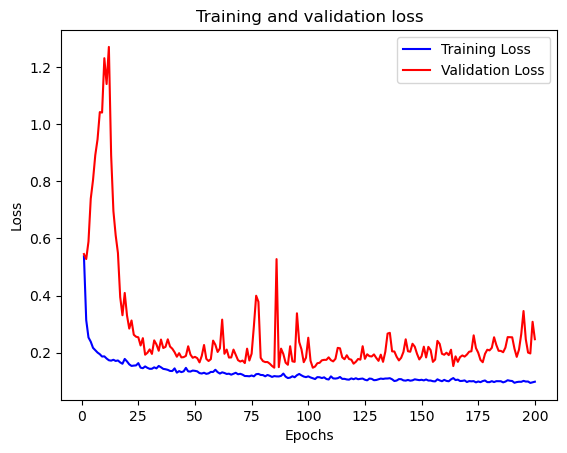

In [24]:
# plot training loss
plt.plot(ep, loss, 'b', label='Training Loss')
# plot validation loss
plt.plot(ep, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### get accuracy scores

In [25]:
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

### plot training and validation accuracy

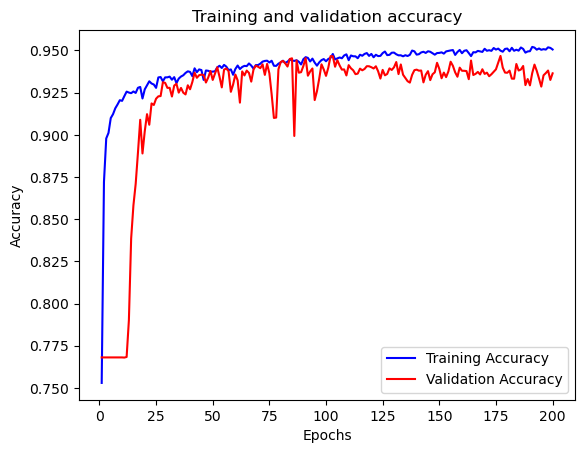

In [26]:
# plot training accuracy
plt.plot(ep, accuracy, 'b', label='Training Accuracy')
# plot validation accuracy
plt.plot(ep, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## compute and print all relevant metrics 

In [30]:
# get "best" epoch
from operator import itemgetter
best_epoch, _ = max(enumerate(val_accuracy), key=itemgetter(1))

# compute all metrics
val_TN = history_dict['val_true_negatives']

val_FP = history_dict['val_false_positives']

val_TP = history_dict['val_true_positives']

val_FN = history_dict['val_false_negatives']

val_sensitivity = history_dict['val_recall']

val_specificity = [x/(x+y) for x,y in zip(val_TN, val_FP)]

val_accuracy = history_dict['val_accuracy']

val_jaccard = [x/(x+y+z) for x,y,z in zip(val_TP, val_FP, val_FN)]

val_dice = [2*x/(2*x+y+z) for x,y,z in zip(val_TP, val_FP, val_FN)]

val_auc = history_dict['val_auc']

# print all relevant metrics for the best epoch of one model

print("Sensitivity: ", val_sensitivity[best_epoch])
print("Specificity: ", val_specificity[best_epoch])
print("Accuracy: ", val_accuracy[best_epoch])
print("Jaccard index: ", val_jaccard[best_epoch])
print("Dice coefficient: ", val_dice[best_epoch])
print("AUC: ", val_auc[best_epoch])

print(val_sensitivity[best_epoch], "&", val_specificity[best_epoch], "&", val_accuracy[best_epoch], "&", val_jaccard[best_epoch], "&", val_dice[best_epoch], "&", val_auc[best_epoch])

Sensitivity:  0.8376122117042542
Specificity:  0.9797108115392852
Accuracy:  0.9467586874961853
Jaccard index:  0.7848665807311533
Dice coefficient:  0.8794680669180778
AUC:  0.9714186787605286
0.8376122117042542 & 0.9797108115392852 & 0.9467586874961853 & 0.7848665807311533 & 0.8794680669180778 & 0.9714186787605286


### get values for ROC curve

In [27]:
from sklearn.metrics import roc_curve, auc

val_preds = model.predict(val_imgs)

fpr, tpr, _ = roc_curve(val_msks.ravel(), val_preds.ravel())
roc_auc = auc(fpr,tpr)

### plot ROC curve

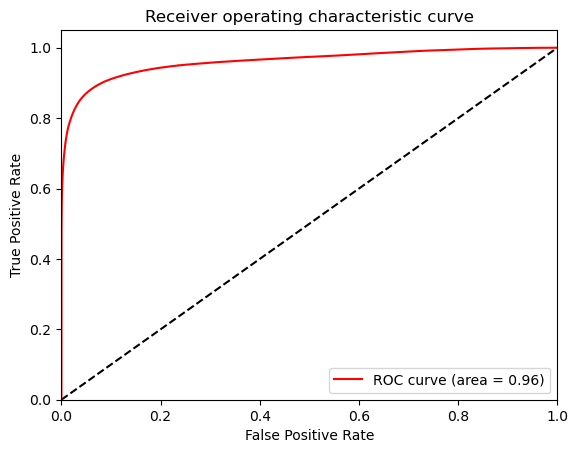

In [28]:
# draw y = x 
plt.plot([0,1], [0,1], 'k--')
# draw roc curve
plt.plot(fpr, tpr, 'r', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.show()

## Generate prediction for one image

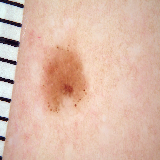

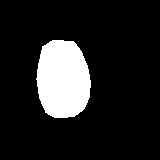

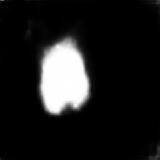

In [31]:
# specify image here
pred = model.predict(val_imgs[0:1])

# Display input image
img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(val_imgs[0]))
display(img)

# Display ground-truth target mask
img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(val_msks[0]))
display(img)

# Display prediction mask
img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(pred[0]))
display(img)